## **COMPARASION METRICS**

Dataset loaded with 20208 transactions and 4185 unique products
Running Apriori algorithm...
Apriori completed with 3004 rules generated
Running Word2Vec model...
Word2Vec completed with 38770 recommendations generated
Evaluating clustering quality...
Clustering evaluation completed

Model Comparison:
                            Metric      Apriori      Word2Vec
0               Execution Time (s)   499.588371     19.000312
1                Memory Usage (MB)  -293.640625     24.613281
2  Number of Rules/Recommendations  3004.000000  38770.000000
3                         Coverage     0.057587      0.926404
4                        Diversity     6.155738      0.096982
5               Clustering Quality     0.570428      0.257460


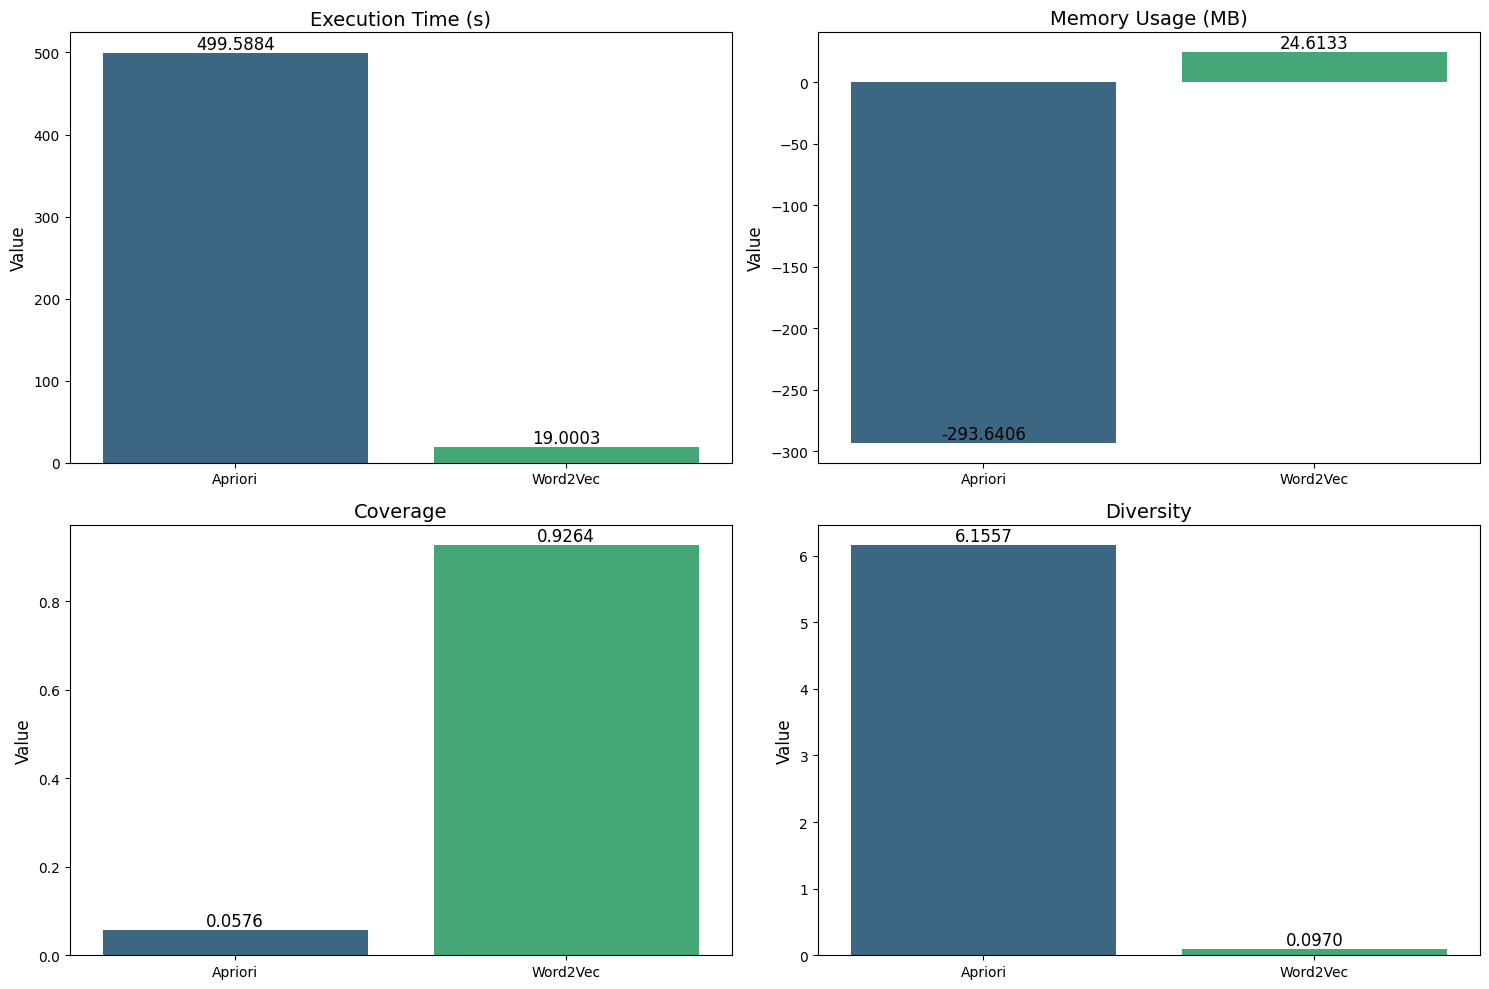

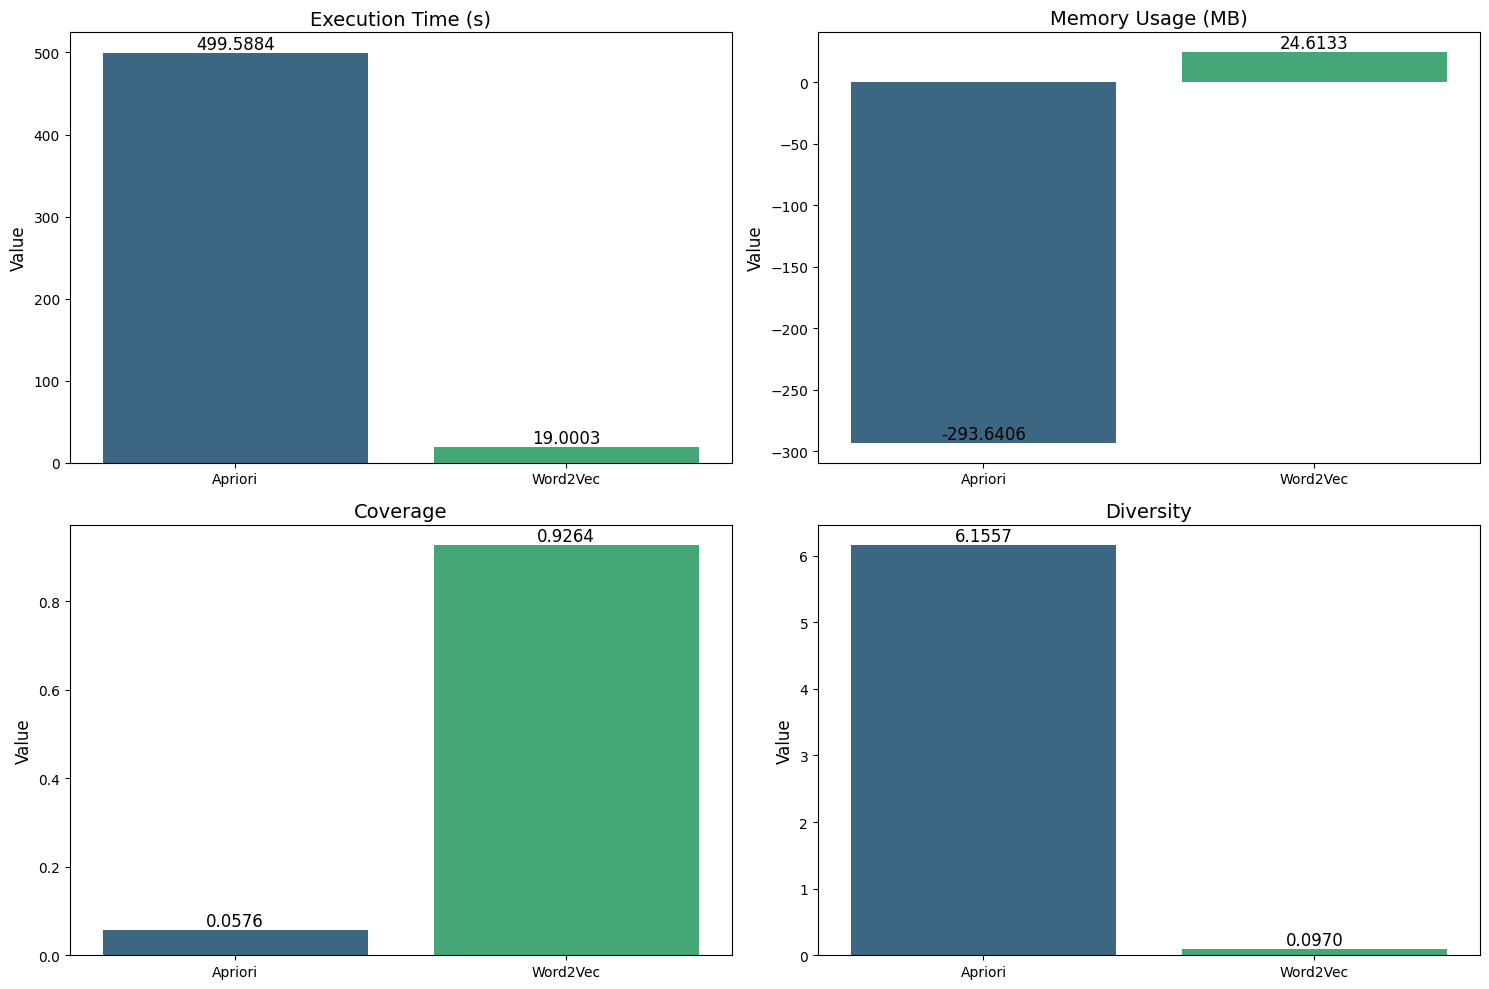

Results saved to C:\Users\moham\Apriori_VS_Word2Vec\Dataset


In [1]:
import pandas as pd
import numpy as np
import os
import time
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class ModelEvaluator:
    """
    Class to evaluate and compare Apriori and Word2Vec models across multiple metrics.
    """
    
    def __init__(self, data_path, excel_file):
        """
        Initialize with dataset path.
        
        Args:
            data_path (str): Path to the data directory
            excel_file (str): Name of the Excel file containing transaction data
        """
        self.data_path = data_path
        self.excel_file = excel_file
        self.file_path = os.path.join(data_path, excel_file)
        self.metrics = {
            'apriori': {},
            'word2vec': {}
        }
        
        # Load dataset
        self.data_excel = pd.read_excel(self.file_path)
        self.data_excel.dropna(subset=['Itemname'], inplace=True)
        
        # Create transaction baskets
        self.basket = self.data_excel.groupby('BillNo')['Itemname'].apply(list)
        self.transactions = self.basket.values.tolist()
        self.unique_products = self.data_excel['Itemname'].unique().tolist()
        
        # Initialize result dataframes
        self.apriori_rules = None
        self.word2vec_complementary = None
        
        print(f"Dataset loaded with {len(self.basket)} transactions and {len(self.unique_products)} unique products")
        
    def run_apriori(self, min_support=0.01, min_confidence=0.05, min_lift=1.2):
        """
        Run Apriori algorithm and measure performance.
        
        Args:
            min_support (float): Minimum support threshold
            min_confidence (float): Minimum confidence threshold
            min_lift (float): Minimum lift threshold
            
        Returns:
            dict: Performance metrics for Apriori
        """
        print("Running Apriori algorithm...")
        
        # Start the process and memory measurement
        process = psutil.Process(os.getpid())
        start_memory = process.memory_info().rss / 1024 / 1024  # MB
        start_time = time.time()
        
        # Convert transactions to binary format
        te = TransactionEncoder()
        te_ary = te.fit(self.transactions).transform(self.transactions)
        basket_encoded = pd.DataFrame(te_ary, columns=te.columns_)
        
        # Generate frequent itemsets
        frequent_itemsets = apriori(basket_encoded, min_support=min_support, use_colnames=True)
        
        # Generate association rules
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        rules = rules[rules['confidence'] >= min_confidence]
        
        # Add antecedent length column
        rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
        
        # Calculate coverage
        rules['coverage'] = rules['antecedent support']
        
        # End time and memory measurement
        end_time = time.time()
        end_memory = process.memory_info().rss / 1024 / 1024  # MB
        
        self.apriori_rules = rules
        
        # Store metrics
        self.metrics['apriori'] = {
            'execution_time': end_time - start_time,
            'memory_usage': end_memory - start_memory,
            'num_rules': len(rules),
            'coverage': self.calculate_apriori_coverage(rules),
            'diversity': self.calculate_apriori_diversity(rules),
        }
        
        # Calculate clustering metrics after running both models
        
        print(f"Apriori completed with {len(rules)} rules generated")
        return self.metrics['apriori']
    
    def run_word2vec(self, vector_size=100, window=5, min_count=2, topn=10):
        """
        Run Word2Vec model and measure performance.
        
        Args:
            vector_size (int): Dimensionality of word vectors
            window (int): Context window size
            min_count (int): Minimum word frequency
            topn (int): Number of top complementary products to generate
            
        Returns:
            dict: Performance metrics for Word2Vec
        """
        print("Running Word2Vec model...")
        
        # Start the process and memory measurement
        process = psutil.Process(os.getpid())
        start_memory = process.memory_info().rss / 1024 / 1024  # MB
        start_time = time.time()
        
        # Train Word2Vec model
        model = Word2Vec(
            sentences=self.transactions,
            vector_size=vector_size,
            window=window,
            sg=1,  # Skip-gram model
            negative=5,  # Negative sampling
            min_count=min_count,
            workers=4,
            epochs=10
        )
        
        # Generate complementary products
        comprehensive_results = []
        
        # Dictionary to store model vocabulary for fast lookup
        model_vocab = set(model.wv.index_to_key)
        
        for product in self.unique_products:
            if product in model_vocab:
                try:
                    similar_products = model.wv.most_similar(product, topn=topn)
                    
                    complementary_list = [
                        {
                            'Original Product': product,
                            'Complementary Product': comp_product,
                            'Similarity Score': similarity,
                            'Rank': rank + 1
                        }
                        for rank, (comp_product, similarity) in enumerate(similar_products)
                    ]
                    
                    comprehensive_results.extend(complementary_list)
                except KeyError:
                    pass
            else:
                pass
        
        complementary_products_df = pd.DataFrame(comprehensive_results)
        
        # End time and memory measurement
        end_time = time.time()
        end_memory = process.memory_info().rss / 1024 / 1024  # MB
        
        self.word2vec_complementary = complementary_products_df
        self.word2vec_model = model
        
        # Store metrics
        self.metrics['word2vec'] = {
            'execution_time': end_time - start_time,
            'memory_usage': end_memory - start_memory,
            'num_recommendations': len(complementary_products_df),
            'coverage': self.calculate_word2vec_coverage(model, complementary_products_df),
            'diversity': self.calculate_word2vec_diversity(complementary_products_df),
        }
        
        print(f"Word2Vec completed with {len(complementary_products_df)} recommendations generated")
        return self.metrics['word2vec']
    
    def calculate_apriori_coverage(self, rules):
        """
        Calculate coverage for Apriori rules.
        
        Args:
            rules (DataFrame): Association rules
            
        Returns:
            float: Coverage score
        """
        # Coverage is defined as the proportion of unique products that appear in rules
        unique_antecedents = set()
        unique_consequents = set()
        
        for _, row in rules.iterrows():
            antecedents = set(row['antecedents'])
            consequents = set(row['consequents'])
            
            unique_antecedents.update(antecedents)
            unique_consequents.update(consequents)
        
        unique_items = unique_antecedents.union(unique_consequents)
        coverage = len(unique_items) / len(self.unique_products)
        
        return coverage
    
    def calculate_word2vec_coverage(self, model, complementary_df):
        """
        Calculate coverage for Word2Vec model.
        
        Args:
            model (Word2Vec): Trained Word2Vec model
            complementary_df (DataFrame): Generated complementary products
            
        Returns:
            float: Coverage score
        """
        # Coverage is defined as the proportion of unique products that have embeddings
        products_with_embeddings = complementary_df['Original Product'].nunique()
        coverage = products_with_embeddings / len(self.unique_products)
        
        return coverage
    
    def calculate_apriori_diversity(self, rules):
        """
        Calculate diversity for Apriori rules.
        
        Args:
            rules (DataFrame): Association rules
            
        Returns:
            float: Diversity score
        """
        # Diversity is measured by the average number of unique consequents per antecedent
        antecedent_consequents = {}
        
        for _, row in rules.iterrows():
            antecedent = frozenset(row['antecedents'])
            consequent = frozenset(row['consequents'])
            
            if antecedent in antecedent_consequents:
                antecedent_consequents[antecedent].add(consequent)
            else:
                antecedent_consequents[antecedent] = {consequent}
        
        # Calculate average number of unique consequents per antecedent
        if len(antecedent_consequents) > 0:
            diversity = sum(len(consequents) for consequents in antecedent_consequents.values()) / len(antecedent_consequents)
        else:
            diversity = 0
        
        return diversity
    
    def calculate_word2vec_diversity(self, complementary_df):
        """
        Calculate diversity for Word2Vec recommendations.
        
        Args:
            complementary_df (DataFrame): Generated complementary products
            
        Returns:
            float: Diversity score
        """
        # Diversity is measured by the proportion of unique complementary products
        total_recommendations = len(complementary_df)
        unique_recommendations = complementary_df['Complementary Product'].nunique()
        
        if total_recommendations > 0:
            diversity = unique_recommendations / total_recommendations
        else:
            diversity = 0
        
        return diversity
    
    def evaluate_clustering(self, n_clusters=5):
        """
        Evaluate clustering quality for both approaches.
        
        Args:
            n_clusters (int): Number of clusters to form
            
        Returns:
            dict: Clustering metrics for both approaches
        """
        print("Evaluating clustering quality...")
        
        # We can only perform clustering if both models have been run
        if self.apriori_rules is None or self.word2vec_complementary is None:
            print("Both models need to be run before evaluating clustering")
            return
        
        # Prepare data for clustering
        
        # Apriori: We'll use lift values to cluster rules
        apriori_features = []
        apriori_items = []
        
        for _, row in self.apriori_rules.iterrows():
            # Use lift, confidence, and support as features
            features = [row['lift'], row['confidence'], row['support']]
            apriori_features.append(features)
            
            # Keep track of the items for interpretation
            antecedent = tuple(sorted(row['antecedents']))
            consequent = tuple(sorted(row['consequents']))
            apriori_items.append((antecedent, consequent))
        
        # Word2Vec: We'll use embeddings to cluster recommendations
        word2vec_features = []
        word2vec_items = []
        
        for _, row in self.word2vec_complementary.iterrows():
            original = row['Original Product']
            complementary = row['Complementary Product']
            
            if original in self.word2vec_model.wv and complementary in self.word2vec_model.wv:
                # Average embeddings of original and complementary products
                original_vec = self.word2vec_model.wv[original]
                complementary_vec = self.word2vec_model.wv[complementary]
                combined_vec = (original_vec + complementary_vec) / 2
                
                # Use first 3 dimensions for clustering
                features = combined_vec[:3].tolist()
                word2vec_features.append(features)
                
                # Keep track of the items for interpretation
                word2vec_items.append((original, complementary))
        
        # Perform clustering if we have data
        apriori_silhouette = None
        word2vec_silhouette = None
        
        if len(apriori_features) > n_clusters:
            # Apply KMeans clustering to Apriori
            apriori_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            apriori_labels = apriori_kmeans.fit_predict(apriori_features)
            
            # Calculate silhouette score
            if len(set(apriori_labels)) > 1:  # Need at least 2 clusters for silhouette
                apriori_silhouette = silhouette_score(apriori_features, apriori_labels)
        
        if len(word2vec_features) > n_clusters:
            # Apply KMeans clustering to Word2Vec
            word2vec_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            word2vec_labels = word2vec_kmeans.fit_predict(word2vec_features)
            
            # Calculate silhouette score
            if len(set(word2vec_labels)) > 1:  # Need at least 2 clusters for silhouette
                word2vec_silhouette = silhouette_score(word2vec_features, word2vec_labels)
        
        # Store clustering metrics
        self.metrics['apriori']['clustering'] = apriori_silhouette
        self.metrics['word2vec']['clustering'] = word2vec_silhouette
        
        print(f"Clustering evaluation completed")
        return {
            'apriori': apriori_silhouette,
            'word2vec': word2vec_silhouette
        }
    
    def compare_models(self):
        """
        Compare performance metrics between Apriori and Word2Vec.
        
        Returns:
            DataFrame: Comparison of metrics
        """
        # Ensure both models have been run
        if not self.metrics['apriori'] or not self.metrics['word2vec']:
            print("Both models need to be run before comparison")
            return
        
        # Create comparison DataFrame
        comparison = pd.DataFrame({
            'Metric': [
                'Execution Time (s)',
                'Memory Usage (MB)',
                'Number of Rules/Recommendations',
                'Coverage',
                'Diversity',
                'Clustering Quality'
            ],
            'Apriori': [
                self.metrics['apriori']['execution_time'],
                self.metrics['apriori']['memory_usage'],
                self.metrics['apriori']['num_rules'],
                self.metrics['apriori']['coverage'],
                self.metrics['apriori']['diversity'],
                self.metrics['apriori'].get('clustering', 'Not evaluated')
            ],
            'Word2Vec': [
                self.metrics['word2vec']['execution_time'],
                self.metrics['word2vec']['memory_usage'],
                self.metrics['word2vec']['num_recommendations'],
                self.metrics['word2vec']['coverage'],
                self.metrics['word2vec']['diversity'],
                self.metrics['word2vec'].get('clustering', 'Not evaluated')
            ]
        })
        
        return comparison
    
    def visualize_comparison(self, save_path=None):
        """
        Visualize comparison metrics between Apriori and Word2Vec.
        
        Args:
            save_path (str, optional): Path to save the visualization
        """
        comparison = self.compare_models()
        
        # Prepare data for plotting
        metrics_to_plot = ['Execution Time (s)', 'Memory Usage (MB)', 'Coverage', 'Diversity']
        
        # Set up the figure
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics_to_plot):
            data = comparison[comparison['Metric'] == metric]
            values = data.iloc[0, 1:].astype(float)
            
            # Create bar plot
            ax = axes[i]
            sns.barplot(x=['Apriori', 'Word2Vec'], y=values, ax=ax, palette='viridis')
            ax.set_title(metric, fontsize=14)
            ax.set_ylabel('Value', fontsize=12)
            ax.set_xlabel('')
            
            # Add values on top of bars
            for j, v in enumerate(values):
                ax.text(j, v, f'{v:.4f}', ha='center', va='bottom', fontsize=12)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def save_results(self, output_dir=None):
        """
        Save evaluation results to files.
        
        Args:
            output_dir (str, optional): Directory to save results
        """
        if output_dir is None:
            output_dir = self.data_path
        
        # Save comparison metrics
        comparison = self.compare_models()
        comparison.to_csv(os.path.join(output_dir, 'model_comparison_metrics.csv'), index=False)
        
        # Save Apriori rules if available
        if self.apriori_rules is not None:
            self.apriori_rules.to_excel(os.path.join(output_dir, 'apriori_rules.xlsx'), index=False)
        
        # Save Word2Vec recommendations if available
        if self.word2vec_complementary is not None:
            self.word2vec_complementary.to_excel(os.path.join(output_dir, 'word2vec_recommendations.xlsx'), index=False)
        
        # Save visualization
        self.visualize_comparison(save_path=os.path.join(output_dir, 'metric_comparison.png'))
        
        print(f"Results saved to {output_dir}")

# Example usage
if __name__ == "__main__":
    # Set file path
    path = r'C:\Users\moham\Apriori_VS_Word2Vec\Dataset'
    excel_file = 'df_merged_items_category.xlsx'
    
    # Initialize evaluator
    evaluator = ModelEvaluator(path, excel_file)
    
    # Run Apriori algorithm with parameters
    evaluator.run_apriori(min_support=0.01, min_confidence=0.05, min_lift=1.2)
    
    # Run Word2Vec model with parameters
    evaluator.run_word2vec(vector_size=100, window=5, min_count=2, topn=10)
    
    # Evaluate clustering
    evaluator.evaluate_clustering(n_clusters=5)
    
    # Compare models
    comparison = evaluator.compare_models()
    print("\nModel Comparison:")
    print(comparison)
    
    # Visualize comparison
    evaluator.visualize_comparison()
    
    # Save results
    evaluator.save_results()